In [9]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
import numpy as np
from pprint import pprint
import random
import time
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import json
from collections import defaultdict
from pprint import pprint
import xml.etree.ElementTree as ET

from imgaug import augmenters as iaa

from PIL import Image
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


In [15]:
with open('annotations/train.json', 'r') as train_json, open('annotations/val.json', 'r') as val_json:
    train_to_cat_map = json.load(train_json)
    val_to_cat_map = json.load(val_json)

10386
1154
[u'car', u'person']


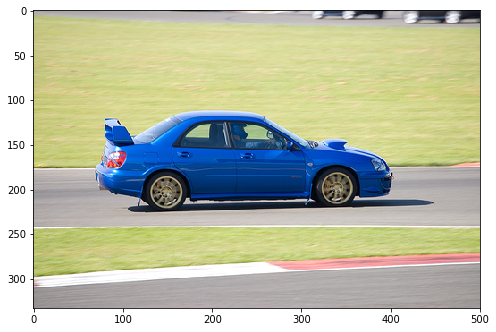

[u'person']


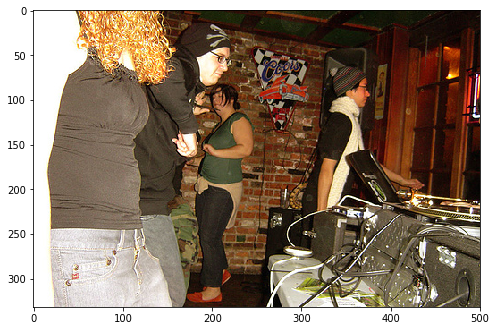

[u'person', u'bottle']


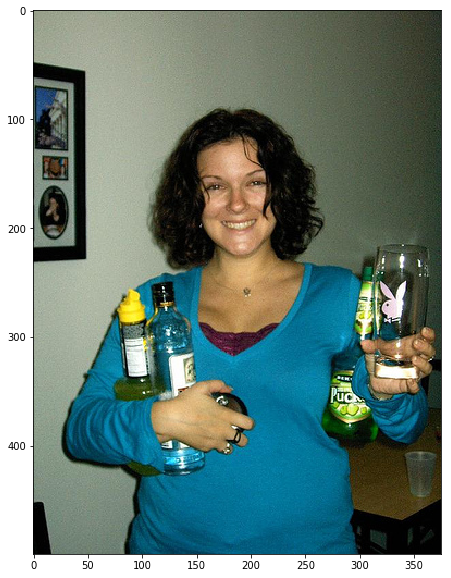

[u'aeroplane']


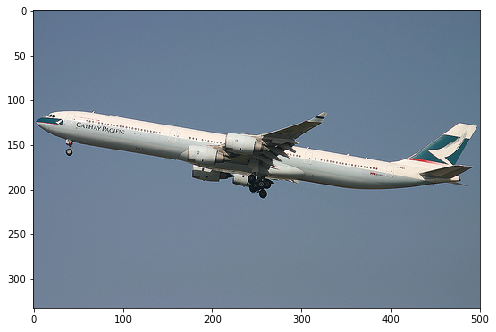

1154
[u'horse', u'person']


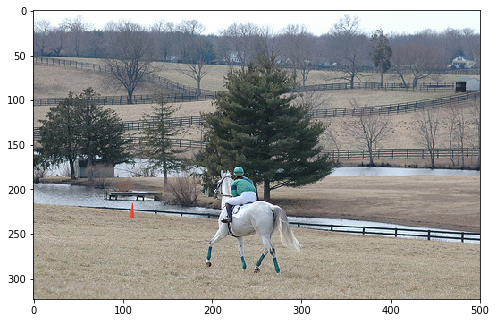

[u'bird']


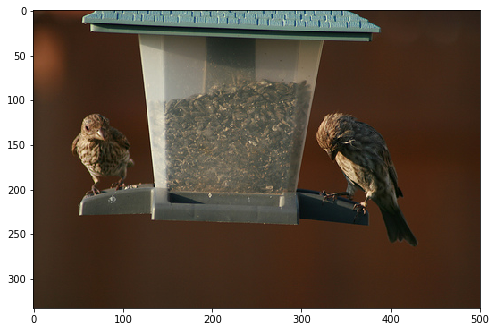

[u'diningtable', u'person']


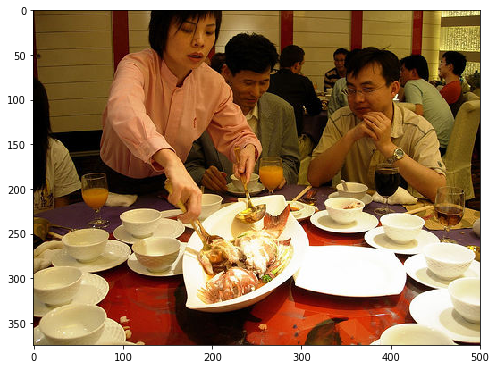

[u'horse']


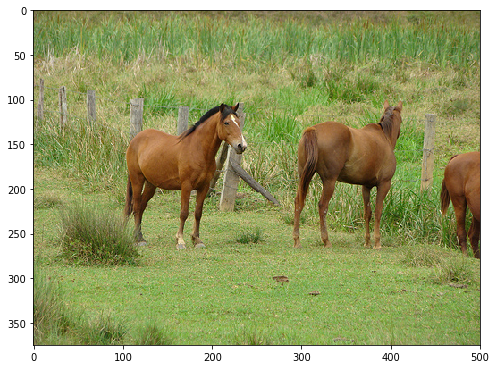

In [16]:
# Validate Images
print len(train_to_cat_map)
print len(val_to_cat_map)

for path, classes in random.sample(train_to_cat_map.items(), 4):
    pprint(classes)
    plt.imshow(Image.open(path))
    plt.show()
    
print len(val_to_cat_map)
for path, classes in random.sample(val_to_cat_map.items(), 4):
    pprint(classes)
    plt.imshow(Image.open(path))
    plt.show()

In [17]:
# The following example shows an augmentation sequence that might be useful for many common experiments. It applies:
# crops and affine transformations to images, 
# flips some of the images horizontally, 
# adds a bit of noise and 
# blur and also changes the contrast as well as brightness.

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order


# Apply the augmentation to an image
def augment_image(img):
    '''
    Input type: PIL image
    output type: PIL image
    '''
    img_arr = np.array(img)
    batch_aug = seq.augment_images([img_arr])
    aug_img = Image.fromarray(batch_aug[0])
    
    return aug_img

10386
[u'bottle', u'person']


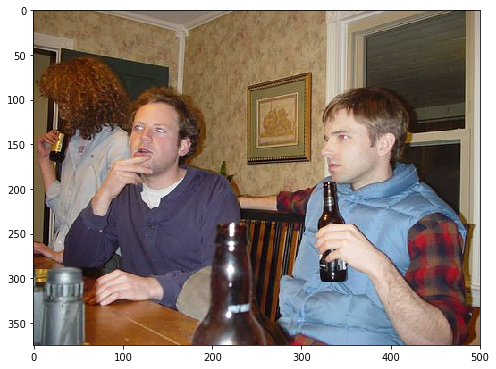

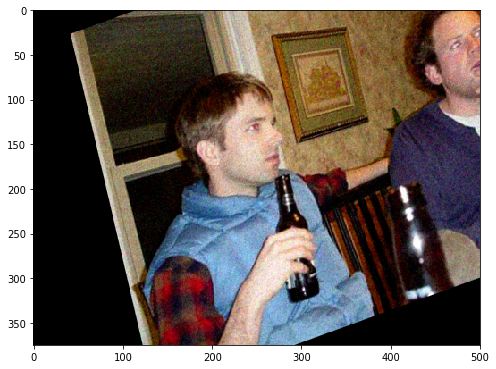

[u'bird']


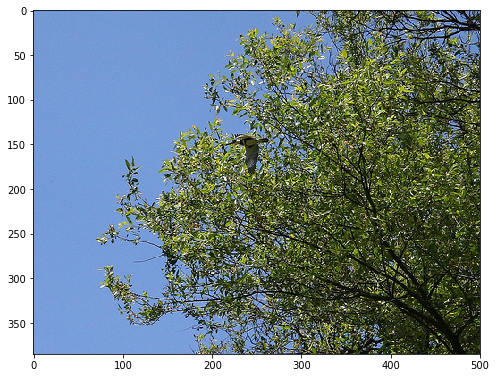

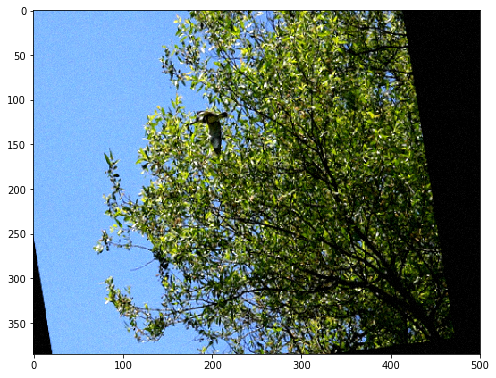

[u'bird']


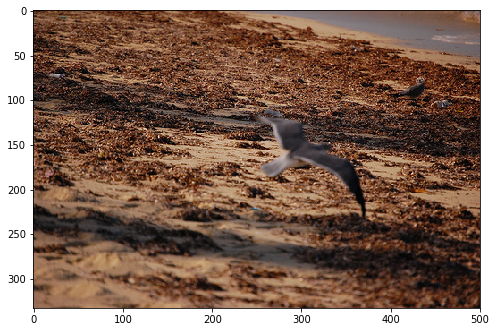

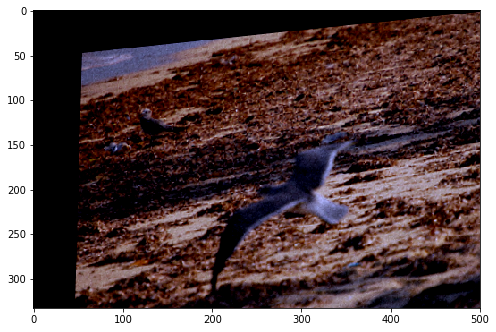

[u'chair', u'sofa', u'tvmonitor']


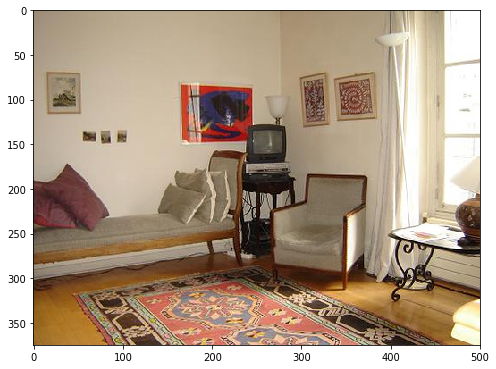

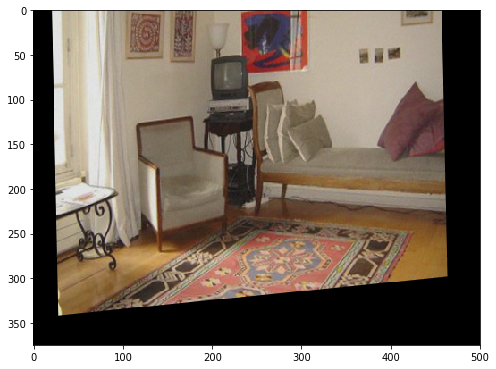

In [18]:
# Validate Augmented Images
print len(train_to_cat_map)

for path, classes in random.sample(train_to_cat_map.items(), 4):
    pprint(classes)
    img = Image.open(path)
    plt.imshow(img)
    plt.show()
    plt.imshow(augment_image(img))
    plt.show()

[u'aeroplane', u'person']


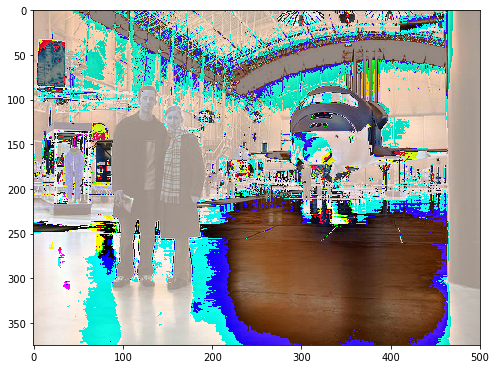

In [19]:
# Visualize Mean Subtraction
for path, classes in random.sample(train_to_cat_map.items(), 1):
    pprint(classes)
    img = Image.open(path)
    arr = preprocess_input(
        np.array(img, dtype=np.float64)[np.newaxis, ...],
    )
    plt.imshow(Image.fromarray(arr.astype(np.uint8)[0, ...]))
    plt.show()

## Train

In [24]:
# Constants
all_categories = []
with open('annotations/categories.txt', 'r') as c:
    all_categories = [x.strip('\n') for x in c.readlines()]
NUM_CLASSES = len(all_categories)
print NUM_CLASSES

20


In [25]:
def balanced_crossentropy(y_true, y_pred, alpha=0.5):
	"""
	y_true: (None, num_classes, 2)
	y_pred: (None, num_classes, 2)
	"""
	y_pred = K.maximum(K.minimum(y_pred, 0.9999), 1e-4)
	multiply = -y_true*K.log(y_pred)
	multiply2 = -((1-y_true)*K.log(1-y_pred))
	pos_loss = K.sum(multiply, axis=1)/(K.sum(y_true, axis=1)+1e-4)
	neg_loss = K.sum(multiply2, axis=1)/(K.sum(1-y_true, axis=1)+1e-4)
	return pos_loss*alpha + neg_loss*(1-alpha)

def focal_loss(y_true, y_pred):
    alpha = 0.5
    gamma = 2
#     y_pred = K.clip(y_pred, 1e-4, 0.9999)
#     inverse_y_true = 1-y_true
#     inverse_y_pred = 1-y_pred
#     inverse_mul = inverse_y_true*inverse_y_pred
#     mul = y_true*y_pred
#     pos_loss = ((1-mul)**gamma)*(1-alpha)*K.log(y_pred)*y_true
#     neg_loss = ((1-inverse_mul)**gamma)*(alpha)*K.log(inverse_y_pred)*inverse_y_true
#     return -K.sum(pos_loss + neg_loss, axis=1)/20.
    pt_a = K.pow((1-y_true)*(1-y_pred), 1-0) + K.pow((y_true*y_pred), 1)
    pt_a = K.clip(pt_a, K.epsilon(), 1-K.epsilon())
    
    pt = (1-y_true)*(1-y_pred) + (y_true*y_pred)
    pt = K.clip(pt, K.epsilon(), 1-K.epsilon())
    
    return -K.mean((K.pow((1-pt),gamma))*K.log(pt), axis=1)

# def TP(y_true, y_pred):
#     return K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

# def TN(y_true, y_pred):
#     return K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))

# def FN(y_true, y_pred):
#     return K.sum(K.round(K.clip((y_true)*(1-y_pred), 0, 1)))

# def FP(y_true, y_pred):
#     return K.sum(K.round(K.clip((1-y_true)*(y_pred), 0, 1)))


def create_per_class_metrics():
    funcs = '''
a = []
    '''
    for index in range(NUM_CLASSES):
        s = '''
def TP_index(y_true, y_pred):
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[index]

def TN_index(y_true, y_pred):
    return K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)), axis=0)[index]

def FN_index(y_true, y_pred):
    return K.sum(K.round(K.clip((y_true)*(1-y_pred), 0, 1)), axis=0)[index]

def FP_index(y_true, y_pred):
    return K.sum(K.round(K.clip((1-y_true)*(y_pred), 0, 1)), axis=0)[index]

a.extend([TP_index, TN_index, FN_index, FP_index])
        '''
        funcs += (s.replace("index", str(index)))
    return funcs

s = create_per_class_metrics()
exec(s)

In [26]:
from keras.optimizers import Adam

# Model parameters
learning_rate = 1e-2
momentum = 0.9
batch_size = 24
nesterov = True
reg_const = 1e-4

# Learning Rate Decay Parameters
monitor='val_loss'
factor = 0.5
patience = 2
epsilon = 0.01
min_lr = 1e-6

# Training parameters
loss = 'binary_crossentropy'
metrics = ['accuracy'] + a
optimizer = SGD(lr=learning_rate, momentum=momentum, nesterov=nesterov)

output_folder = './baseline_model_overfit/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [27]:
# Callback to save metrics to a file
class SaveCustomMetrics(keras.callbacks.Callback):
    def __init__(self, output_folder):
        self.output_folder=output_folder
        
    def on_epoch_end(self, epoch, logs):
        data = dict()
        with open(os.path.join(self.output_folder, 'custom_logs.json'), 'r') as of:
            data=json.load(of)
            
        data[epoch]=logs
        with open(os.path.join(self.output_folder, 'custom_logs.json'), 'w') as of:
            json.dump(data, of)


# Save per batch training times
class BatchTimer(keras.callbacks.Callback):
    def __init__(self, output_folder):
        self.output_folder=output_folder
        
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch=epoch
        
    def on_batch_begin(self, batch, logs={}):
        self.batch_time_start = time.time()

    def on_batch_end(self, batch, logs={}):
        output_file = os.path.join(output_folder, 'batch_times.txt')
        batch_time = time.time() - self.batch_time_start
        with open(output_file, 'at') as of:
            of.write('{epoch} {batch} {time}\n'.format(epoch=self.epoch, batch=batch, time=batch_time))
            

In [28]:
# Build and compile model
xception = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
)

# xception = Xception(
#     include_top=False,
#     weights='imagenet',
#     input_shape=None,
# )

dense_input = GlobalAveragePooling2D()(xception.output)
outputs = []
# for c in all_categories:
#     d = Dense(1, activation='sigmoid', name="{}_output".format(c.replace(" ", "_")))(dense_input)
#     outputs.append(d)
    
dout = Dense(NUM_CLASSES, activation='sigmoid', name="output")(dense_input)
outputs.append(dout)
    
model = Model([xception.input], outputs)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
    reg_const=reg_const
)

In [14]:
# Create data generator
from keras.applications.resnet50 import preprocess_input
def create_generator(x, y, batch_size=32, load_fn_x=Image.open, load_fn_y=lambda y:y, shuffle=True):
    if len(x) != len(y):
        raise ValueError("Length of x and y are not equal.")
   
    x_data, y_data = x, y
    if shuffle:
        zipped = zip(x,y)
        random.shuffle(zipped)
        x_data, y_data = zip(*zipped) # Unzip
        
    index = 0
    while True:
        batch_x, batch_y = [], []
        for _ in range(batch_size):
            try:
                index += 1
                index %= len(x_data)
                img = load_fn_x(x_data[index])
                if np.array(img).shape == (224,224):
                    continue

                batch_x.append(img)
                batch_y.append(load_fn_y(y_data[index]))
                
            except IOError as e:
                print e
                continue
#         batch_y = list(np.expand_dims(np.array(batch_y).T, axis=-1))
#         batch_x = [preprocess_input(np.array(x).astype(float)) for x in batch_x]
        yield (preprocess_input(np.array(batch_x).astype(float)), np.array(batch_y).astype(float))

In [15]:
# Init data generator and create binary y vectors
def load_fn_x(x):
    img = Image.open(x)
    img = img.resize((224,224))
#     img = augment_image(img)
    return np.array(img)

def multihot(y):
    to_index = lambda i: all_categories.index(i)
    y_new = map(to_index, y)
    return np.max(to_categorical(y_new, NUM_CLASSES), axis=0)

x_train, y_train = zip(*train_to_cat_map.items())
train_data_gen = create_generator(
    x_train,
    y_train,
    batch_size,
    load_fn_x=load_fn_x,
    load_fn_y=multihot,
    shuffle=True
)

x_val, y_val = zip(*val_to_cat_map.items())
val_data_gen = create_generator(
    x_val,
    y_val,
    batch_size,
    load_fn_x=load_fn_x,
    load_fn_y=multihot,
    shuffle=True
)

['horse' 'person']


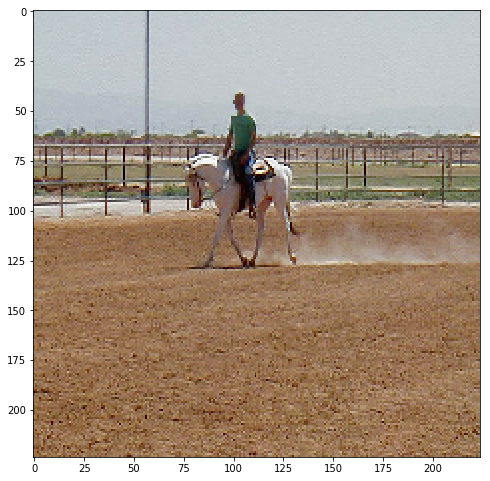

['tvmonitor']


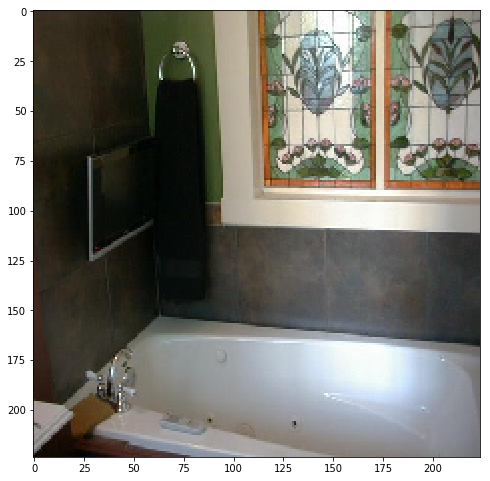

['bird']


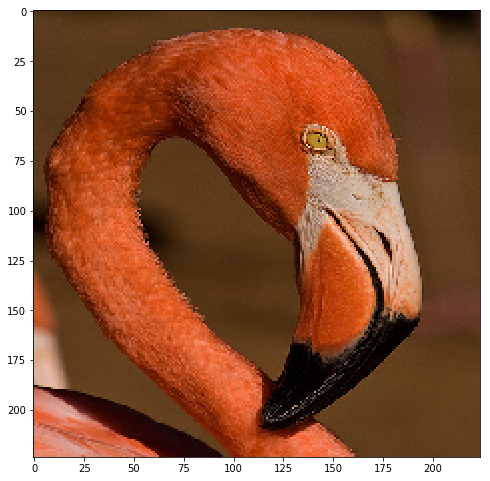

In [16]:
# Verify Generator Output
batch_x, batch_y = train_data_gen.next()
# batch_y = np.squeeze(batch_y).T
for (x,y) in random.sample(zip(batch_x, batch_y), 3):
    print np.array(all_categories)[np.squeeze(y.astype(np.bool))]
    plt.imshow(x)
    plt.show()

In [ ]:
LOAD_WEIGHTS = False
if LOAD_WEIGHTS:
    model.load_weights('./scpd/model_30.h5')

In [ ]:
# Custom callbacks
batch_timer = BatchTimer(output_folder)
custom_logger = SaveCustomMetrics(output_folder)

# LR Decay
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,
    factor=factor,
    patience=patience,
    verbose=1,
    epsilon=epsilon,
    min_lr=min_lr
)

# Train
model.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=1000,
    epochs=1000,
    validation_data=val_data_gen,
    validation_steps=50,
    verbose=1,
    folder=output_folder,
    callbacks=[batch_timer, reduce_lr],
    overwrite=True
)

In [ ]:
!ls baseline_model/

In [ ]:
with open('baseline_model_/logs.json', 'r') as d:
    logs = json.load(d)
    
from pprint import pprint
pprint(logs['val_loss'])
for val in logs:
    if 'loss' not in val:
        continue
    print val
    plt.plot(logs[val])
    plt.show()

In [ ]:
val_x, val_y = val_data_gen.next()
model.predict_on_batch(val_x[:10])